In [1]:
# 4次元データ
import numpy as np
x = np.random.rand(10, 1, 28, 28)
x.shape

(10, 1, 28, 28)

In [2]:
x[0].shape

(1, 28, 28)

In [3]:
x[1].shape

(1, 28, 28)

In [4]:
x[0, 0].shape

(28, 28)

In [5]:
x[0, 0]

array([[0.39306944, 0.39258221, 0.83755357, 0.54253722, 0.46708034,
        0.67089171, 0.71831255, 0.98025213, 0.47761512, 0.25901481,
        0.32584829, 0.56325975, 0.12899117, 0.81693293, 0.79087862,
        0.21698993, 0.07628293, 0.67216739, 0.80352697, 0.27084547,
        0.87004438, 0.84546502, 0.92374841, 0.10332397, 0.14655203,
        0.5357175 , 0.65938462, 0.3651124 ],
       [0.8737905 , 0.80050039, 0.46035195, 0.47596828, 0.2932048 ,
        0.27508998, 0.89579936, 0.08761305, 0.24121804, 0.90199842,
        0.24305512, 0.91273664, 0.77925368, 0.75826825, 0.57212771,
        0.78556193, 0.80827757, 0.67253085, 0.80873222, 0.76452365,
        0.54466713, 0.99329643, 0.42893729, 0.74781068, 0.74581658,
        0.53209211, 0.24946559, 0.11276948],
       [0.18480603, 0.55858179, 0.64690382, 0.82518707, 0.42506482,
        0.8522002 , 0.79969185, 0.97300105, 0.19442024, 0.43044254,
        0.59377272, 0.63107475, 0.23738865, 0.16877247, 0.40211591,
        0.57902983, 0.8877

In [6]:
# numpy padding
# 1次元配列
a = [2, 3]
b = np.pad(a, [1,0], "constant")
print(b) # 先頭に1個、末尾に0個 0パディング
c = np.pad(a, [1,2], "constant")
print(c) # 先頭に1個、末尾に2個 0パディング

# 2次元配列
d = [[1,2], [3,4]]
e = np.pad(d, [(1,2),(3,4)], "constant")
print(e) # 行の先頭に1行、行末に2行、左の列に3行、右の列に4行

[0 2 3]
[0 2 3 0 0]
[[0 0 0 0 0 0 0 0 0]
 [0 0 0 1 2 0 0 0 0]
 [0 0 0 3 4 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


In [7]:
#np.zeros((2, 3, 3, 3, 2, 2))

In [8]:
# im2col(image to column)

def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    # input_data : (dataNum, ch, height, width)
    # pad : パディング
    
    # return col: 2次元配列
    
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    
    
                             # 個数方向, ch方向, 行方向、 列方向
    img = np.pad(input_data, [(0,0), (0,0), (pad,pad), (pad,pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [9]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad

    Returns
    -------

    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [10]:
# im2colを使う
x1 = np.random.rand(1,3,7,7) # 1個のデータ
fil_h = 5
fil_w = 5
col1 = im2col(x1, fil_h, fil_w, stride=1, pad=0)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7) # 10個のデータ
col2 = im2col(x2, fil_h, fil_w, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


In [11]:
# Convolutionレイヤ
class Convolution:
    # フィルターサイズが重みW
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # backward用
        self.x = None
        self.col = None
        self.col_w = None
        
        self.dW = None
        self.db = None
        
    def forward(self, x):
        # xは４次元データ
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int((H + 2*self.pad - FH)/self.stride + 1)
        out_w = int((W + 2*self.pad - FW)/self.stride + 1)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        # フィルタの個数は入力データN個(バッチサイズ)でFN個のみ
        col_W = self.W.reshape(FN, -1).T # フィルターの展開 # N個のそれぞれの1つ目のフィルタによるブロックは順番に行に挿入される
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2) # (N, FN, out_h, out_w)
        
        self.x = x
        self.col = col
        self.col_W = col_W
        return out
    
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        # dout(N, FN, out_h, out_w) -> (N, out_h, out_w, FN)
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN) # (N, FN, out_h, out_w)を(#(N*分割ブロック数), FN)に変換
        
        self.db = np.sum(dout, axis=0) # バッチ内の個数単位で合計
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        
        dcol = np.dot(dout, self.col_W.T) # 2次元
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad) # 4次元
        
        # Convolution内部では4次元->2次元->2次元
        return dx

In [12]:
# Poolingレイヤ
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        # backward用
        
        self.x = None
        self.arg_max = None
        
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int((H - self.pool_h)/self.stride + 1)
        out_w = int((W - self.pool_w)/self.stride + 1)
        
        # 展開(1)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w) # 1チャネルの1フィルタの値が列をなす行を作る
        
        # 最大値(2)
        out = np.max(col, axis=1)
        
        # backward用
        arg_max = np.argmax(col, axis=1)
        self.arg_max = arg_max
        
        # 整形(3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        self.x = x
        
        
        return out
    
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1) # (N, C, out_h, out_w) -> (N, out_h, out_w, C)

        pool_size = self.pool_h*self.pool_w
        dmax = np.zeros((dout.size, pool_size)) # 1列の個数は1フィルタブロック*N

        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,))

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

        return dx

In [13]:
x = np.random.randn(2, 3, 4, 2)
print(x.shape)
x.size

(2, 3, 4, 2)


48

In [14]:
x

array([[[[-2.45271193, -0.97364744],
         [ 0.54538116, -1.50692132],
         [-0.33446808,  0.07275991],
         [-0.14843256, -1.12671648]],

        [[ 0.43428211, -0.1616315 ],
         [ 1.55441513,  1.03600255],
         [-0.84353015, -0.63776027],
         [ 1.26770957, -0.85110847]],

        [[ 0.64433424, -0.30993471],
         [-0.11469489,  0.94370336],
         [ 0.75526105, -1.37770427],
         [ 0.43196037, -0.09814835]]],


       [[[ 0.99672789, -0.24995163],
         [-0.14984452, -0.07201555],
         [-0.19426536, -0.5466863 ],
         [-1.06022015, -0.33362985]],

        [[ 0.56152968,  0.87063086],
         [-2.18383873,  1.58048642],
         [ 1.07670277, -0.60168269],
         [ 0.5722494 , -1.46550435]],

        [[ 0.51728742,  1.02556607],
         [-0.61469622, -1.03680352],
         [-1.39902381,  0.00622228],
         [-0.34442495,  1.61176446]]]])

In [15]:
x.flatten()

array([-2.45271193, -0.97364744,  0.54538116, -1.50692132, -0.33446808,
        0.07275991, -0.14843256, -1.12671648,  0.43428211, -0.1616315 ,
        1.55441513,  1.03600255, -0.84353015, -0.63776027,  1.26770957,
       -0.85110847,  0.64433424, -0.30993471, -0.11469489,  0.94370336,
        0.75526105, -1.37770427,  0.43196037, -0.09814835,  0.99672789,
       -0.24995163, -0.14984452, -0.07201555, -0.19426536, -0.5466863 ,
       -1.06022015, -0.33362985,  0.56152968,  0.87063086, -2.18383873,
        1.58048642,  1.07670277, -0.60168269,  0.5722494 , -1.46550435,
        0.51728742,  1.02556607, -0.61469622, -1.03680352, -1.39902381,
        0.00622228, -0.34442495,  1.61176446])

In [16]:
def affine(x, w, b):
    return np.dot(x, w) + b

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
        # テンソル対応
        self.original_x_shape = None
        
    def forward(self, x):
        #self.x = x
        
        # テンソル対応
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1) # 4次元を2次元に変換
        self.x = x
        
        out = np.dot(x, self.W) + self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW= np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        # 入力データの形状に戻す（テンソル対応）
        dx = dx.reshape(*self.original_x_shape)
        
        return dx

In [17]:
def relu(x):
    return np.max(0, x)

class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self, z):
        self.mask = (z <= 0)
        out = z.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout):
        # Reluレイヤのforward入力とbackward出力は同じ次元
        dout[self.mask] = 0
        return dout

In [18]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T
    
    x = x - np.max(x) # オーバーフロー対策
    y = np.exp(x) / np.sum(np.exp(x))
    return y

In [19]:
def cross_entropy_error(y, t):
    """
    # 交差エントロピーの入力(softmaxの出力)は1xN
    if y.ndim == 1: # 1サンプルのみのとき
        z = z.reshape(1, z.size) # (*,) -> (1,*)に変更
        y = y.reshape(1, y.size)
    
    batch_size = y.shape[0]
    #print("y.shape", y.shape)
    #print("t.shape", t.shape)
    #print("y.size", y.size)
    #print("t.size", t.size)
    # テストデータがラベリングのとき
    if y.size != t.size:
        t_one_hot = np.zeros_like(y, dtype=np.int) # one_hot表現の雛形
        for index in range(batch_size):
            #print('index', index)
            #print('t[index]', t[index])
            t_one_hot[index, int(t[index])] = 1
        t = t_one_hot # 変換
    
    # tをone-hot表現に変換してから交差エントロピーを計算する
    return -np.sum(t * np.log(y)) / batch_size 
    """
    # 以下、サンプル通り
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    #print('t:', t)        
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

In [20]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # Softmaxの出力
        self.t = None
        self.x = None
        
    def forward(self, x, t):
        self.t = t
        self.x = x
        self.y = softmax(x)
        
        #print('self.y', self.y.shape)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        
        # テストデータがone-hot-vector表現の場合
        if self.t.size == self.y.size:
            dx = (self.y - self.t) / batch_size # サンプル1個あたりの誤差勾配
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
            
        return dx

In [21]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        it.iternext()   
        
    return grad

In [22]:
# CNNの実装
# [Convolution - ReLU - Pooling - Affine - ReLU - Affine - Softmax]
from collections import OrderedDict
import numpy as np
import pickle

class SimpleConvNet:
    # input_dim=(チャネル、画像の高さ, 画像の幅)
    def __init__(self, 
                 input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100,
                 output_size=10,
                 weight_init_std=0.01):
        
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        
        input_size = input_dim[1] # Height and Width of img
        conv_output_size = (input_size + 2*filter_pad - filter_size)/filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        
        # 重みパラメータの初期化を行うパート
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size) # 入力数, 出力数
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        # レイヤの作成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], 
                                           self.params['b1'], 
                                           conv_param['stride'], 
                                           conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        
        self.last_layer = SoftmaxWithLoss()
        
    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db
        
        return grads
    
    
    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]
    
    
    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])
            
        return grads
    
    
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

            
    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

In [23]:
# Stochastic Gradient Descent
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [24]:
# Momentum
# v <- αV - η*dL/dW
# W <- W + v
# vは速度, -η*dL/dWが加速度
# 勾配がきつい所ほど、更新の値が大きい
# α 減速項

class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

In [25]:
# AdaGrad
# learning rate decay 徐々に学習係数を小さくする
# 学習係数を全体で一括して下げるのではなく、一つ一つのパラメータに対して個々で減衰させる
# h <- dL/dW ⦿ dL/dW ※⦿は要素毎の掛け算 つまりhは勾配の２乗和を加算したもの
# W <- W - (η/√h) * dL/dW
# hは学習が進むに連れて、大きくなるが逓減する
# 1/√hはh=0で無限大、hが増加するに連れて小さくなる

class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [26]:
# Adam ≒　Momentum + AdaGrad
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        self.h = 1e-7 # ゼロ割防止の為の微小値

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key, val in params.items():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + self.h)

In [27]:
class RMSprop:
    def __init__(self, lr=0.01, decay_rate=0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        self.e = 1e-7 # ゼロ割を防ぐための微小値

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1.0 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + self.e)

In [28]:
class Nesterov:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] *= self.v[key]
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1.0 + self.momentum) * self.lr * self.v[key]

In [29]:
import sys, os
import numpy as np
from mnist import load_mnist

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

In [30]:
class Trainer:
    """ニューラルネットの訓練を行うクラス
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprpo':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))


train loss:2.2987308863816347
=== epoch:1, train acc:0.271, test acc:0.217 ===
train loss:2.2966087278608907
train loss:2.292173087268165
train loss:2.288319501856595
train loss:2.2797741956333972
train loss:2.2646118442708927
train loss:2.2490996564925383
train loss:2.2265329470595274
train loss:2.209158381681098
train loss:2.1619132978922067
train loss:2.1556923698067187
train loss:2.1406208700333096
train loss:2.0607414525402747
train loss:1.991675404119468
train loss:1.9634372279918164
train loss:1.8694528787857112
train loss:1.814351391251882
train loss:1.6727484917487891
train loss:1.6016442983716102
train loss:1.6472877686388463
train loss:1.5556966662394769
train loss:1.5152726981640618
train loss:1.4833734985124403
train loss:1.2076168787001706
train loss:1.1885450387800176
train loss:1.1045256804736352
train loss:1.0962516824850197
train loss:1.092655406117911
train loss:0.9179880537771623
train loss:0.8157958754403026
train loss:0.8273218470835663
train loss:0.93290247522890

train loss:0.2850639614431844
train loss:0.19106306766345252
train loss:0.2353225017922048
train loss:0.16218540060466385
train loss:0.29659965787402404
train loss:0.2192279472211648
train loss:0.21498048977670325
train loss:0.2695410465551765
train loss:0.26087717847567826
train loss:0.2604491184226302
train loss:0.26429431220332655
train loss:0.34384275735874253
train loss:0.29272175355456925
train loss:0.24432817014915273
train loss:0.16386062034889368
train loss:0.14978937775314813
train loss:0.2516251081256218
train loss:0.3160299156629773
train loss:0.2756743508991112
train loss:0.19118503320887018
train loss:0.21424390302676527
train loss:0.13343446595046204
train loss:0.2000212066630936
train loss:0.1414255076742932
train loss:0.22606262076338582
train loss:0.16925679384358144
train loss:0.17811347696856245
train loss:0.1383794271605833
train loss:0.1505504588944528
train loss:0.29748091908162044
train loss:0.1701895761194245
train loss:0.12861269011850285
train loss:0.10307485

train loss:0.14126987000135227
train loss:0.13512852082615015
train loss:0.09150061156427687
train loss:0.10321537710397279
train loss:0.04848165385438916
train loss:0.059895963734582676
train loss:0.09453561124216446
train loss:0.048425557553635715
train loss:0.07124974905834777
train loss:0.13420924464472236
train loss:0.1458283850276938
train loss:0.17353027161479498
train loss:0.11686165049011692
train loss:0.14633510173673067
train loss:0.17652725573879188
train loss:0.07441532407679978
train loss:0.1450142711710761
train loss:0.17799264193295466
train loss:0.15816998336895785
train loss:0.08717073903343418
train loss:0.13979540373918087
train loss:0.07784783386572239
train loss:0.10302191577173651
train loss:0.10164554475099384
train loss:0.10032834991048796
train loss:0.17736874361605828
train loss:0.076828107689313
train loss:0.2983186021406514
train loss:0.30624632014354997
=== epoch:12, train acc:0.953, test acc:0.943 ===
train loss:0.09160452671847187
train loss:0.0948404794

train loss:0.1137967444651696
train loss:0.017617510749506633
train loss:0.03963822803689172
train loss:0.04334864551282316
train loss:0.04088370106385108
train loss:0.046762804741415344
train loss:0.07314510096897169
train loss:0.07153432690980872
train loss:0.031055264279654046
train loss:0.046215643300072745
train loss:0.04043058897265928
train loss:0.0461516453807534
train loss:0.01937763344060239
train loss:0.04010768704127577
train loss:0.05612311024920512
train loss:0.030031695664608428
train loss:0.09147004083753815
train loss:0.08291583942090103
train loss:0.027740717386860406
train loss:0.01671395386088276
train loss:0.029951995154909757
train loss:0.028659739027530426
train loss:0.043586186662504
=== epoch:17, train acc:0.986, test acc:0.951 ===
train loss:0.022377125504381624
train loss:0.047809029432742525
train loss:0.04326756007765105
train loss:0.028049798588236734
train loss:0.03917882542000939
train loss:0.059154610113620484
train loss:0.043883736624429986
train loss:

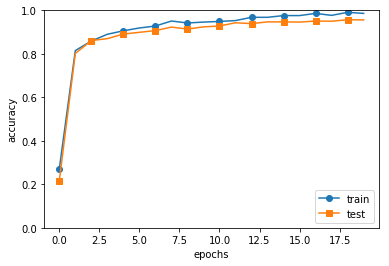

In [31]:
max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
%matplotlib inline
import matplotlib.pyplot as plt
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

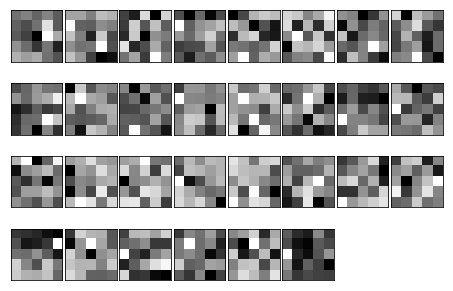

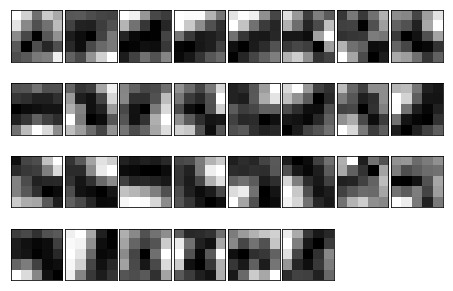

In [32]:
def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("params.pkl")
filter_show(network.params['W1'])